# Canny Edge Detector
$p.30 \sim p.53$

1. Gaussian filter
2. Find the intensity gradient of the image

  a. Apply a pair of convolution masks

  ![](https://i.imgur.com/EiYaObX.png)

  b. Find the gradient strength and direction with:

  ![](https://i.imgur.com/U5FEiKe.png)

3. Non-maximum Suppression
4. Thresholding edges
5. Hysteresis: The final step. Canny does use two thresholds (upper and lower):
>If a pixel gradient is higher than the upper threshold, the pixel is accepted as an edge
If a pixel gradient value is below the lower threshold, then it is rejected.
If the pixel gradient is between the two thresholds, then it will be accepted only if it is connected to a pixel that is above the upper threshold.
Canny recommended a upper:lower ratio between 2:1 and 3:1.

[Canny Edge Detector](https://docs.opencv.org/master/da/d5c/tutorial_canny_detector.html)

In [ ]:
from google.colab import drive
import os
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Class File')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt

## Step 1. Gaussian filter

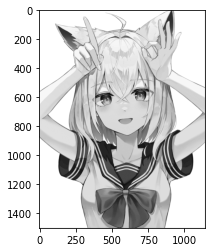

In [ ]:
from scipy import signal, misc
# 讀取灰階圖片
img_org = cv2.imread("fubuki.jpg",0)
KernelSize = 3
def Gaussian_Filter(KernelSize,image):
    sigma = 0.3*((KernelSize-1)*0.5 - 1) + 0.8
    kernel = []    
    total=0 #各係數相加後總值
    for i in range(0,KernelSize):
        for j in range(0,KernelSize):
          kernel = np.fromfunction(lambda i, j: (1/(2*math.pi*sigma**2)) * math.e ** ((-1*((i-(KernelSize-1)/2)**2+(j-(KernelSize-1)/2)**2))/(2*sigma**2)), (KernelSize, KernelSize))

    resx = np.array(kernel)/np.sum(kernel)
    resx = scipy.signal.convolve2d(image, resx, mode='same', boundary='fill', fillvalue=0)
    return resx

img = Gaussian_Filter(KernelSize,img_org)
plt.imshow(img, cmap='gray')
plt.show()

## Step 2. Filter image with derivative of Gaussian
![](https://i.imgur.com/G4e6Z4n.png)

In [194]:
def sobel(img, filtering_type):

    h, w = img.shape
    output = np.zeros(img.shape)
    
    Gx = np.zeros(img.shape)
    Gy = np.zeros(img.shape)
    
    horizontal = np.array(([-1, 0, 1], [-2, 0, 2], [-1, 0, 1]))
    vertical = np.array(([-1, -2, -1], [0, 0, 0], [1, 2, 1]))
    
    if filtering_type=='dx': 
      for i in range(1, h - 1):
          for j in range(1, w - 1):
              Gx[i, j] = np.sum(np.multiply(img[i - 1 : i + 2, j - 1 : j + 2], horizontal))
              Gy[i, j] = 0
    elif filtering_type=='dy':
      for i in range(1, h - 1):
          for j in range(1, w - 1):
              Gx[i, j] = 0
              Gy[i, j] = np.sum(np.multiply(img[i - 1 : i + 2, j - 1 : j + 2], vertical)) 
    elif filtering_type=='magnitude': 
      for i in range(1, h - 1):
          for j in range(1, w - 1):
              Gx[i, j] = np.sum(np.multiply(img[i - 1 : i + 2, j - 1 : j + 2], horizontal))
              Gy[i, j] = np.sum(np.multiply(img[i - 1 : i + 2, j - 1 : j + 2], vertical))           
    
    gradient = np.sqrt(np.square(Gx) + np.square(Gy))
    output = np.clip(gradient, 0 , 255)
    
    angle = np.rad2deg(np.arctan2(Gy, Gx))
    angle[angle < 0] += 180
    output = output.astype('uint8')

    return output, angle

In [195]:
sobel_y,_ = sobel(img, 'dy')
sobel_x,_ = sobel(img, 'dx')
sobel_m,_ = sobel(img, 'magnitude')

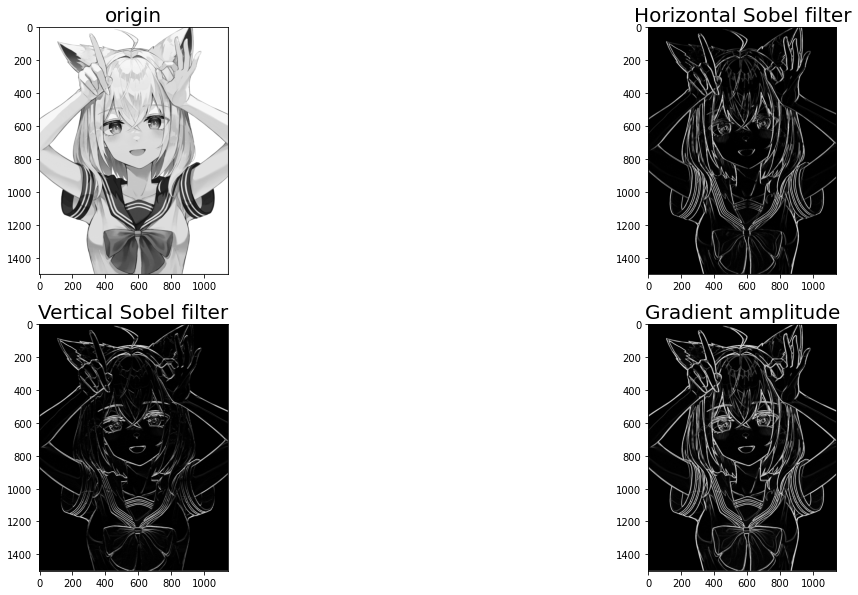

In [197]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))

plt.subplot(2, 2, 1)
plt.title('origin', fontsize=20)
plt.imshow(img, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Horizontal Sobel filter', fontsize=20)
plt.imshow(sobel_x, cmap='gray')
           
plt.subplot(2, 2, 3)
plt.title('Vertical Sobel filter', fontsize=20)
plt.imshow(sobel_y, cmap='gray')
           

plt.subplot(2, 2, 4)
plt.title('Gradient amplitude', fontsize=20)
plt.imshow(sobel_m, cmap='gray')

![](https://i.imgur.com/iuck4AQ.png)

## Step 3. Non-maximum Suppression

Non maximum suppression without interpolation requires us to divide the 3x3 grid of pixels into 8 sections. Ie. if the gradient direction falls in between the angle -22.5 and 22.5, then we use the pixels that fall between this angle (r and q) as the value to compare with pixel p, see image below.

![](https://i.imgur.com/55DLrWn.png)

In [198]:
def non_maximum_suppression(gradient, angles):

    gradient_copy = gradient.copy()
    height,width= gradient.shape
    output = np.zeros(gradient.shape)

    for i in range(1, height-1 ):
        for j in range(1, width-1):
            #0~22.5度，157.5~180度 為 0 度區間
            if (0 <= angles[i, j] < 22.5) or (157.5 <= angles[i, j] <= 180):
                value_to_compare = max(gradient_copy[i, j - 1], gradient_copy[i, j + 1])
            #22.5~67.5度 為 45度區間
            elif (22.5 <= angles[i, j] < 67.5):
                value_to_compare = max(gradient_copy[i - 1, j - 1], gradient_copy[i + 1, j + 1])
            #67.5~112.5度 為 90度區間
            elif (67.5 <= angles[i, j] < 112.5):
                value_to_compare = max(gradient_copy[i - 1, j], gradient_copy[i + 1, j])
            #112.5~157.5度 為 135度區間
            else:
                value_to_compare = max(gradient_copy[i + 1, j - 1], gradient_copy[i - 1, j + 1])
            
            if gradient_copy[i, j] >= value_to_compare:
                output[i, j] = gradient_copy[i, j]
    output = np.multiply(output, 255.0 / output.max())
    return output

gradient, angle = sobel(img, 'magnitude')
After_non_maximum_supression = non_maximum_suppression(gradient, angle)

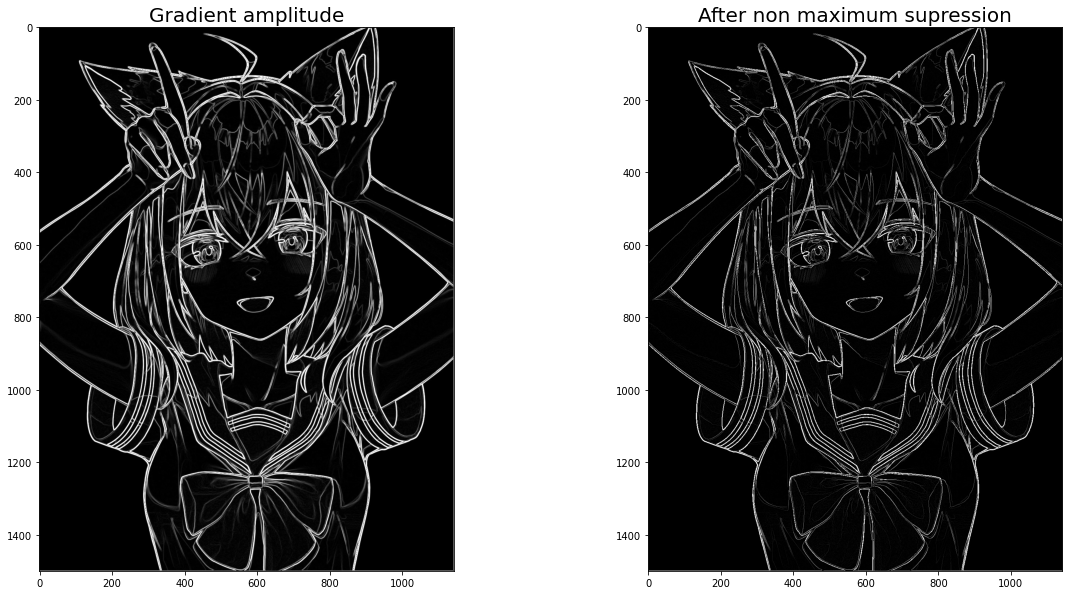

In [199]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))

plt.subplot(1, 2, 1)
plt.title('Gradient amplitude', fontsize=20)
plt.imshow(gradient, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('After non maximum supression', fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')

![](https://i.imgur.com/YHCIcql.png)


## Step 4. Thresholding edges

In [228]:
def seperate(img, minimum = 60, maximum = 120):
    weak = 20
    strong = 255
    
    size = img.shape
    output = np.zeros(size)
    weak_x, weak_y = np.where((img > minimum) & (img <= maximum))
    strong_x, strong_y = np.where(img >= maximum)
    output[strong_x, strong_y] = strong
    output[weak_x, weak_y] = weak
    return output

thresholding = seperate(After_non_maximum_supression)

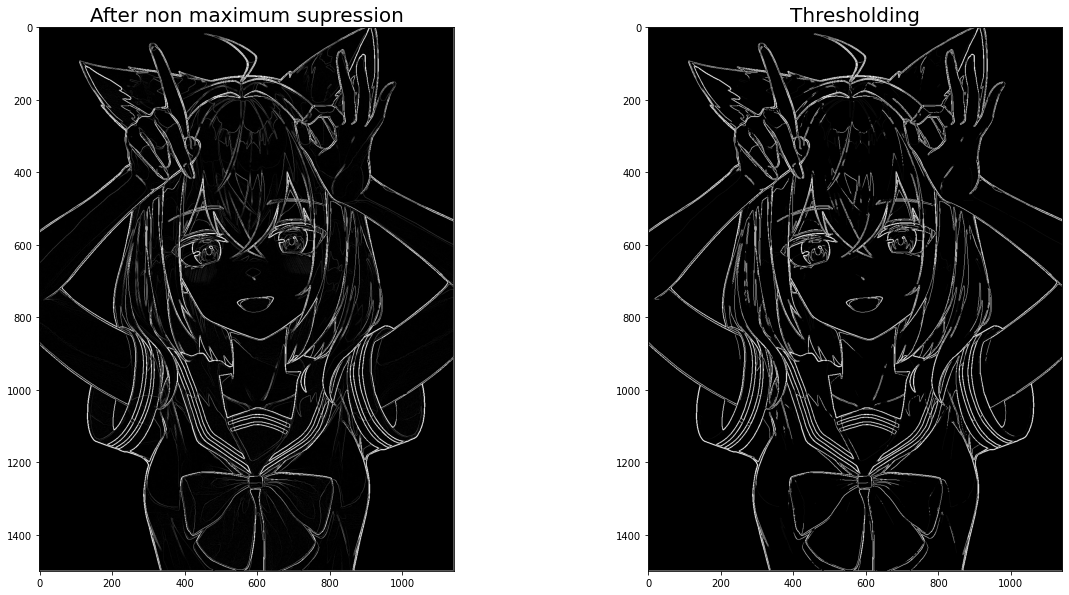

In [229]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))

plt.subplot(1, 2, 1)
plt.title('After non maximum supression', fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')

plt.subplot(1, 2, 2)
plt.title('Thresholding', fontsize=20)
plt.imshow(thresholding, cmap='gray')

![](https://i.imgur.com/cYbJayE.png)

## Step 5. Hysteresis
![](https://i.imgur.com/GEu9stb.png)

In [234]:
def connect(img):

    height, width = img.shape
    weak = 20
    strong = 255

    for i in range(1, height-1):
        for j in range(1, width-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass

    return img

dst_img = connect(thresholding)

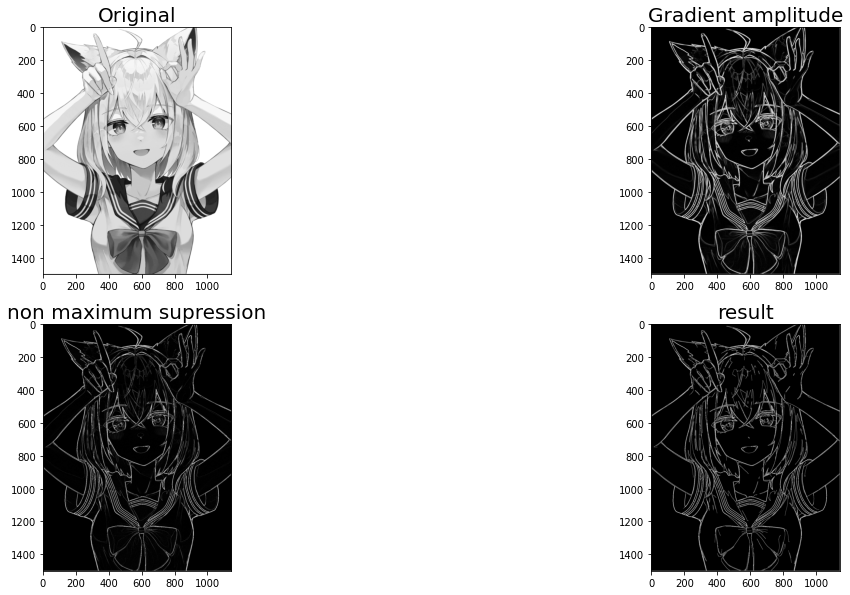

In [235]:
fig, ax = plt.subplots(2, 2, figsize=(20,10))

plt.subplot(2, 2, 1)
plt.title('Original', fontsize=20)
plt.imshow(img, cmap='gray')

plt.subplot(2, 2, 2)
plt.title('Gradient amplitude', fontsize=20)
plt.imshow(gradient, cmap='gray')

plt.subplot(2, 2, 3)
plt.title('non maximum supression', fontsize=20)
plt.imshow(After_non_maximum_supression, cmap='gray')


plt.subplot(2, 2, 4)
plt.title('result', fontsize=20)
plt.imshow(dst_img, cmap='gray')

![](https://i.imgur.com/G0q98le.png)

# Canny Edge OpenCV 套件


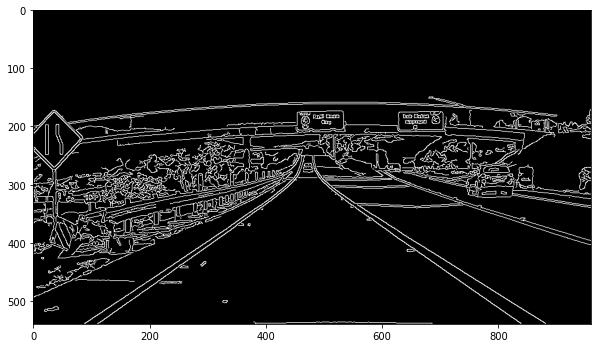

In [ ]:
low_threshold = 15
high_threshold = 90
kernel_size = 3
#這邊較低的threshold用於檢測圖像中明顯的邊緣，較高的threshold則將間斷的邊緣連接起來。
plt.figure(figsize=(10,18))
img2 = cv2.imread("highway.jpg",0)
gray_blur = cv2.GaussianBlur(img2,(kernel_size, kernel_size),0)
edges = cv2.Canny(gray_blur, low_threshold, high_threshold)
plt.imshow(edges, cmap='Greys_r')
plt.show()